# Deep Metric Learning with FAU's Papyrus Collection

## Customize Notebook and Install Dependencies

In [1]:
!pip install albumentations==0.4.6
!pip install faiss-gpu
!pip install pytorch-metric-learning
!pip install efficientnet_pytorch

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [3]:
!pip install PyPDF2
!pip install FPDF

# For Timo's code
from tqdm import tqdm_notebook as tqdm
from skimage import io, transform
from PyPDF2 import PdfFileMerger
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import drive
from shutil import copyfile
from os import listdir
from fpdf import FPDF
import pandas as pd
import numpy as np
import time
import toml
import os

# For custom dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# From Kevin Musgraves GitHub
from efficientnet_pytorch import EfficientNet
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

# For Logging
from scipy.interpolate import make_interp_spline

# Notebook Seetings
tqdm().pandas()
import matplotlib
from matplotlib import rc
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng



!rm "log.txt"
import logging
#logging.basicConfig(filename="test.log", level=logging.INFO )
logger = logging.getLogger('log')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('log.txt')
fh.setLevel(logging.INFO)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(ch)
logger.addHandler(fh)
logger.propagate = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
if False:
  info_path = './gdrive/MyDrive/mt/data/06_test/processed_info.csv'
  info_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames_raw':str,'fnames':str,'fragmentID':int,'papyID':int,'posinfo':str, 'pixelCentimeter':float, 'Simpleposinfo':str,'papyPosID':str}, header=0)
  info_frame.papyPosID = info_frame.papyPosID.str.replace('v','0')
  info_frame.papyPosID = info_frame.papyPosID.str.replace('r','1')
  info_frame.papyPosID = info_frame.papyPosID.astype(int)
  info_frame.to_csv(info_path)

## Prepare Dataset

In [6]:
def get_info(path):
    info_path = join(path, 'info.csv')
    if isfile(info_path): 
        info_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames_raw':str,
                                                                'fnames':str,
                                                                'fragmentID':int,
                                                                'papyID':int,
                                                                'posinfo':str,
                                                                'pixelCentimeter':float,
                                                                'Simpleposinfo':str,
                                                                'papyPosID':int}, header=0)
    else:
        fnames = [f for f in listdir(path) if isfile(join(path, f))]
        fnames = [ x for x in fnames if ".jpg" in x ]
        fnames = [f.split('.',1)[0] for f in fnames]
        info_frame = pd.DataFrame(fnames, columns=['fnames'])
        info_frame['papyID'] = info_frame.fnames.apply(lambda x: x.split('_',1)[0])
        info_frame['posinfo'] = info_frame.fnames.apply(lambda x: ''.join(filter(str.isalpha, x)))
        info_path = join(path, 'info.csv')
        info_frame['pixelCentimer'] = info_frame.fnames.progress_apply(get_estimated_resulution)
        split_info_frame = pd.DataFrame(info_frame['pixelCentimer'].tolist(), columns=['pixelCM_Y','pixelCM_X'])
        info_frame = pd.concat([info_frame, split_info_frame], axis=1)
        info_frame.drop('pixelCentimer', axis=1, inplace=True)       
        info_frame['pixelCM'] = info_frame[['pixelCM_Y','pixelCM_X']].max(axis=1)
        info_frame.drop(columns=['pixelCM_X','pixelCM_Y'], inplace=True)
        info_frame.to_csv(info_path)        
        time.sleep(10)
    return info_frame

In [7]:
def retrive_size_by_fname(fname):
  path = './gdrive/MyDrive/mt/data/'
  info_frame = get_info(path=path)
  return float(info_frame.loc[info_frame['fnames'] == fname]['pixelCM'])

In [8]:
def create_processed_info(path):
  info_path = join(path, 'processed_info.csv')
  if isfile(info_path):
    processed_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames':str,'papyID':int,'posinfo':str, 'pixelCentimer':float}, header=0)    
  else:    
    fnames = [f for f in listdir(path) if isfile(join(path, f))]
    fnames = [ x for x in fnames if ".png" in x ]
    fnames = [f.split('.',1)[0] for f in fnames]
    fnames_frame = pd.DataFrame(fnames,columns=['fnames'])
    fragmentID = pd.DataFrame([f.split('_',1)[0] for f in fnames], columns=['fragmentID'])
    fnames_raw = [f.split('_',1)[1] for f in fnames]
    processed_frame = pd.DataFrame(fnames_raw, columns=['fnames_raw'])
    
    processed_frame = pd.concat([processed_frame, fnames_frame], axis=1)

    processed_frame = pd.concat([processed_frame, fragmentID], axis=1)
    processed_frame['papyID'] = processed_frame.fnames_raw.apply(lambda x: x.split('_',1)[0])
    processed_frame['posinfo'] = processed_frame.fnames_raw.apply(lambda x: ''.join(filter(str.isalpha, x)))
    processed_frame['pixelCentimer'] = processed_frame.fnames_raw.progress_apply(retrive_size_by_fname)
    processed_frame.to_csv(info_path)
     
  return processed_frame

In [9]:
class FAUPapyrusCollectionDataset(Dataset):
    """FAUPapyrusCollection dataset."""
    def __init__(self, root_dir, processed_frame, transform=None):

        self.root_dir = root_dir
        self.processed_frame = processed_frame
        self.transform = transform

    def __len__(self):
        return len(self.processed_frame)       

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.processed_frame.iloc[idx, 1])
        
        img_name = img_name + '.png'
        """
        image = io.imread(img_name , plugin='matplotlib')        
        if self.transform:
            image = self.transform(image)
        """
        image = cv2.imread(img_name, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
          image = self.transform(image = image)['image']

        papyID = self.processed_frame.iloc[idx,7 ]


        return image, papyID
        #sample

## Helper Functions

In [10]:
### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [11]:
def create_output_dir(name, experiment_name, x=1):
  
  while True:
        dir_name = (name + (str(x) + '_iteration_' if x is not 0 else '') + 'of_experiment_' + experiment_name).strip()
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)            

            return dir_name
        else:
            x = x + 1

In [12]:
def replace_helper(some_list_1, some_list_2):
  new_list_1 = []
  new_list_2 = []

  for string_a, string_b in zip(some_list_1,some_list_2):     
    new_list_1.append(str(string_a).replace("_", " "))
    new_list_2.append(str(string_b).replace("_", " "))

  return new_list_1, new_list_2

## Model Definition

In [13]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))        
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Define Training

In [14]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)        
        loss.backward()        
        optimizer.step()

        # Console-Logging
        if batch_idx % 20 == 0:
          logger.info(f' Training:')
          logger.info(f'  Mined Tiplets {mining_func.num_triplets}')
          logger.info(f'  Loss {loss}')
            
    return loss, mining_func.num_triplets

## Define Validation

In [15]:
def validation(model, loss_func, mining_func, device, eval_loader, optimizer, train_set, eval_set, accuracy_calculator,epoch):
    model.eval()
    
    for batch_idx, (data, labels) in enumerate(eval_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)              

        # Console-Logging
        if batch_idx % 20 == 0:
          logger.info(f' Validation:')
          logger.info(f'  Mined Tiplets: {mining_func.num_triplets}')
          logger.info(f'  Loss{loss}')
                  
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    eval_embeddings, eval_labels = get_all_embeddings(eval_set, model)

    train_labels = train_labels.squeeze(1)
    eval_labels = eval_labels.squeeze(1)

    accuracies = accuracy_calculator.get_accuracy(
        eval_embeddings, train_embeddings, eval_labels, train_labels, False
    )  
    logger.info(f'  AMI {accuracies["AMI"]}')
    logger.info(f'  NMI {accuracies["NMI"]}')
    logger.info(f'  MAP {accuracies["mean_average_precision"]}')
    logger.info(f'  P@1 {accuracies["precision_at_1"]}')
    

    return loss, mining_func.num_triplets, accuracies["AMI"], accuracies["NMI"], accuracies["mean_average_precision"], accuracies["precision_at_1"]

## Define Testing

In [16]:
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator, epoch):

    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )  

    # Console-Logging
    logger.info(f' Test:')
    logger.info(f'  AMI {accuracies["AMI"]}')
    logger.info(f'  NMI {accuracies["NMI"]}')
    logger.info(f'  MAP {accuracies["mean_average_precision"]}')
    logger.info(f'  P@1 {accuracies["precision_at_1"]}')

    return accuracies["AMI"], accuracies["NMI"], accuracies["mean_average_precision"], accuracies["precision_at_1"]

## Visualizatin and Logging

In [17]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [18]:
def plot_loss(train_loss_values, val_loss_values, epochs, output_path):  
  
  epochs = np.arange(1, epochs + 1)
  train_loss_values = np.array(train_loss_values)
  val_loss_values = np.array(val_loss_values)
  plt.style.use('seaborn')
  width = 460
  
  if True:
    tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.loc":'lower left'
    }

    plt.rcParams.update(tex_fonts)
  
  fig, ax = plt.subplots(1, 1, figsize=set_size(width))

  # plot original lines
  ax.plot(epochs, train_loss_values, 'b', label='Training Loss', linestyle='dotted')
  ax.plot(epochs, val_loss_values, 'g', label='Validation Loss', linestyle='dotted')

  # plot smoothed lines
  epochs_smooth = np.linspace(epochs.min(), epochs.max(), 300)
  a_BSpline_train = make_interp_spline(epochs, train_loss_values)
  a_BSpline_val = make_interp_spline(epochs, val_loss_values)

  train_loss_smooth =  a_BSpline_train(epochs_smooth)
  val_loss_smooth = a_BSpline_val(epochs_smooth)
  ax.plot(epochs_smooth, train_loss_smooth, 'b', label='Training Smoothed Loss')
  ax.plot(epochs_smooth, val_loss_smooth, 'g', label='Validation Smoothed Loss')

  
  ax.set_title('Training and Validation Loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()
  # Save and remove excess whitespace
  fig.savefig(output_path + '/loss.pdf', format='pdf', bbox_inches='tight')
  fig.close()

In [19]:
def plot_acc(val_AMI_values, val_NMI_values,val_mean_average_precision_values, val_precision_at_1_values, epochs, output_path):  
  epochs = np.arange(1, epochs + 1)
  plt.style.use('seaborn')
  width = 460
  tex_fonts = {
      # Use LaTeX to write all text
      "text.usetex": True,
      "font.family": "serif",
      # Use 10pt font in plots, to match 10pt font in document
      "axes.labelsize": 10,
      "font.size": 10,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 8,
      "xtick.labelsize": 8,
      "ytick.labelsize": 8,
      "legend.loc":'lower left'
  }
  plt.rcParams.update(tex_fonts)
  
  fig, ax = plt.subplots(1, 1, figsize=set_size(width))
  ax.plot(epochs, val_AMI_values, 'b', label=' Val AMI', linestyle='dotted', linewidth=.3)
  ax.plot(epochs, val_NMI_values, 'g', label='Val NMI', linestyle='dotted', linewidth=.3)
  ax.plot(epochs, val_mean_average_precision_values, 'r', label='Val MAP', linestyle='dotted', linewidth=.3)
  ax.plot(epochs, val_precision_at_1_values, 'm', label='Val P@1', linestyle='dotted', linewidth=.3)

  epochs_smooth = np.linspace(epochs.min(), epochs.max(), 300)
  a_BSpline_AMI = make_interp_spline(epochs, val_AMI_values)
  a_BSpline_NMI = make_interp_spline(epochs, val_NMI_values)
  a_BSpline_mean_average_precision = make_interp_spline(epochs, val_mean_average_precision_values)
  a_BSpline_precision_at_1 = make_interp_spline(epochs, val_precision_at_1_values)
  val_AMI_values_smooth =  a_BSpline_AMI(epochs_smooth)
  val_NMI_values_smooth = a_BSpline_NMI(epochs_smooth)
  train_loss_smooth_smooth =  a_BSpline_mean_average_precision(epochs_smooth)
  val_loss_smooth_smooth = a_BSpline_precision_at_1(epochs_smooth)

  ax.plot(epochs_smooth, val_AMI_values_smooth, 'b', label='Val AMI Smoothed', linewidth=.6)
  ax.plot(epochs_smooth, val_NMI_values_smooth, 'g', label='Val NMI Smoothed', linewidth=.6)
  ax.plot(epochs_smooth, train_loss_smooth_smooth, 'r', label='Val MAP Smoothed', linewidth=.6)
  ax.plot(epochs_smooth, val_loss_smooth_smooth, 'm', label='Val P@1 Smoothed ', linewidth=.6)  
  ax.set_title('Validation Accuracy')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Accuracy')
  ax.legend()
  fig.savefig(output_path + '/acc.pdf', format='pdf', bbox_inches='tight')
  fig.close()

In [20]:
def plot_table(setting, param, dml_param, output_path):  
  width = 460
  plt.style.use('seaborn-bright')
  tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
  plt.rcParams.update(tex_fonts)

  ########## Plot Settings ##################
  setting_name_list = list(setting.keys())
  setting_value_list = list(setting.values())
  setting_name_list, setting_value_list = replace_helper(setting_name_list, setting_value_list)
  vals = np.array([setting_name_list, setting_value_list], dtype=str).T
  fig, ax = plt.subplots(1, 1, figsize=set_size(width))
  ax.table(cellText=vals, colLabels=['Setting', 'Value'], loc='center', zorder=3, rowLoc='left', cellLoc='left')
  ax.set_title('Experiment Settings')
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(output_path + '/settings.pdf', format='pdf', bbox_inches='tight')

  ########## Plot Params ##################
  param_name_list = param.keys()
  param_value_list = param.values()
  param_name_list, param_value_list = replace_helper(param_name_list, param_value_list)
  param_vals = np.array([list(param_name_list), list(param_value_list)], dtype=str).T
  fig, ax = plt.subplots(1, 1, figsize=set_size(width))
  ax.table(cellText=param_vals, colLabels=['Hyperparameter', 'Value'], loc='center', zorder=3, rowLoc='left', cellLoc='left')
  ax.set_title('Hyperparaeters')
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(output_path + '/params.pdf', format='pdf', bbox_inches='tight')

  ########## Plot DML Params ##################
  dml_param_name_list = dml_param.keys()
  dml_param_value_list = dml_param.values()
  dml_param_name_list, dml_param_value_list = replace_helper(dml_param_name_list, dml_param_value_list)
  dml_param_vals = np.array([list(dml_param_name_list), list(dml_param_value_list)], dtype=str).T  
  fig, ax = plt.subplots(1, 1, figsize=set_size(width))
  ax.table(cellText=dml_param_vals, colLabels=['DML Hyperparameter', 'Value'], loc='center', zorder=3, rowLoc='left', cellLoc='left')
  ax.set_title('DML Hyperparameters')
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(output_path + '/dml_params.pdf', format='pdf', bbox_inches='tight')
  fig.close()

In [21]:
def gradient_visualization(parameters, results_folder: str):
    """
    Returns the parameter gradients over the epoch.
    :param parameters: parameters of the network
    :type parameters: iterator
    :param results_folder: path to results folder
    :type results_folder: str
    """
    tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.loc":'lower left'
}

    plt.rcParams.update(tex_fonts)

    ave_grads = []
    layers = []


    for n, p in parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, linewidth=1, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient Visualization")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(results_folder + "/gradients.pdf")

In [22]:
def create_logging(setting, param, dml_param, train_loss_values, val_loss_values, val_AMI_values, val_NMI_values,val_mean_average_precision_values, val_precision_at_1_values, epochs, output_dir):
  plot_table(setting, param, dml_param, output_dir)
  
  plot_loss(train_loss_values, val_loss_values, epochs, output_dir)
  plot_acc(val_AMI_values, val_NMI_values,val_mean_average_precision_values, val_precision_at_1_values, epochs, output_dir)
  

  pdfs = ['/loss.pdf', '/acc.pdf', '/params.pdf','/dml_params.pdf', '/settings.pdf','/HistogramFragAfterTrain.pdf','/HistogramFragAfterVal.pdf', '/HistogramFragTest.pdf', '/gradients.pdf']
  bookmarks = ['Loss', 'Accuracy', 'Hyperparameters','DML Hyperparameters', 'Seetings', 'HistogramTrain', 'HistrogramVal', 'HistrogramTest','Gradients']

  merger = PdfFileMerger()

  for i, pdf in enumerate(pdfs):
      merger.append(output_dir + pdf, bookmark=bookmarks[i])
  
  pdf = FPDF()   
  pdf.add_page() 
  pdf.set_font("Helvetica", size = 6)
  # open the text file in read mode
  f = open("log.txt", "r")
  
  # insert the texts in pdf
  for x in f:
    pdf.cell(200, 6, txt = x, ln = 1, align = 'l')

    # save the pdf with name .pdf
  pdf.output("log.pdf")   
  merger.append("log.pdf", bookmark='Log')
  merger.write(output_dir + "/report.pdf")
  merger.close()
  
  copyfile('log.txt', output_dir + '/log.txt')

In [23]:
def remove_empty_bins(counts):
  ticks = range(len(counts))
  new_ticks = []
  new_counts = []
  for tick, count in zip(ticks, counts):
    if count != 0:
      new_ticks.append(str(tick))
      new_counts.append(count)
  return new_ticks, new_counts

In [24]:
def get_cleand_papyri_hist(processed_frame, title, fig_name):
  id_series = processed_frame.groupby('papyPosID')['fnames'].nunique().sort_values(ascending=False)
  counts = np.bincount(id_series)  
  ticks, counts = remove_empty_bins(counts)
  plt.style.use('seaborn')
  width = 460


  tex_fonts = {
      # Use LaTeX to write all text
      "text.usetex": True,
      "font.family": "serif",
      # Use 10pt font in plots, to match 10pt font in document
      "axes.labelsize": 10,
      "font.size": 10,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 8,
      "xtick.labelsize": 8,
      "ytick.labelsize": 8,
      "legend.loc":'lower left'
  }

  plt.rcParams.update(tex_fonts)

  fig, ax = plt.subplots(1, 1, figsize=set_size(width))

  rects = ax.bar(ticks, counts, width=.5, align='center')
  ax.set(xticks=ticks, xlim=[-1, len(ticks)], title=title, ylabel='Number of papyri',xlabel='Number of fragments per papyri')

  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),xy=(rect.get_x() + rect.get_width() / 2, height),xytext=(0, 3), textcoords="offset points",ha='center', va='baseline')

  autolabel(rects)

  fig.tight_layout()
  fig.savefig(fig_name, format='pdf', bbox_inches='tight')
  fig.close()
  plt.show()

# Start Experiment

In [25]:
def train_and_validate(config_path):
  logger.info(f'Initilization  -------------------------')
  config = toml.load(config_path)
  setting = config.get('settings')
  logger.info(f' Start Experiment {setting["experiment_name"]}')
  param = config.get('params')
  dml_param = config.get('dml_params')
  output_dir = create_output_dir(setting['output'], setting['experiment_name'])
  device = torch.device(setting['env'])

  """
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.CenterCrop(param['center_crop']),
      transforms.Normalize((param['normalize_0'],
                            param['normalize_1'],
                            param['normalize_2']),
                            (param['normalize_3'],
                             param['normalize_4'],
                             param['normalize_5'],))]
  )
  """
  
  transform = A.Compose(
      [A.PadIfNeeded(min_height=param['padding_height'],min_width=param['padding_width']),       
       A.CenterCrop (param['center_crop_height'], param['center_crop_width'], always_apply=False, p=1.0),
       A.Normalize(mean = (param['normalize_0'], param['normalize_0'], param['normalize_0']),std  = (param['normalize_0'], param['normalize_0'], param['normalize_0'])),
       ToTensorV2()])

  if setting['debug']:
    logger.info(f' Debug Mode: YES')
    processed_frame = create_processed_info(setting['path_debug'])
    logger.info(f' Create Processed Info Frame: DONE')

    dataset1 = FAUPapyrusCollectionDataset(setting['path_debug'], processed_frame, transform)
    logger.info(f' Create Train Data Set DONE')

    dataset2 = FAUPapyrusCollectionDataset(setting['path_debug'], processed_frame, transform)
    logger.info(f' Create Val Data Set DONE')

    dataset3 = FAUPapyrusCollectionDataset(setting['path_debug'], processed_frame, transform)
    logger.info(f' Create Test Data Set DONE')
  else:
    processed_frame = create_processed_info(setting['path_train'])
    get_cleand_papyri_hist(processed_frame, title = 'Histogram Fragments / Papyri  [Train]', fig_name=output_dir + '/HistogramFragAfterTrain.pdf')
    dataset1 = FAUPapyrusCollectionDataset(setting['path_train'], processed_frame, transform)
    logger.info(f' Create Train Data Set DONE')

    processed_frame = create_processed_info(setting['path_val'])
    get_cleand_papyri_hist(processed_frame, title = 'Histogram Fragments / Papyri  [Val]', fig_name=output_dir +  '/HistogramFragAfterVal.pdf')
    dataset2 = FAUPapyrusCollectionDataset(setting['path_val'], processed_frame, transform)
    logger.info(f' Create Val Data Set DONE')

    processed_frame = create_processed_info(setting['path_test'])
    get_cleand_papyri_hist(processed_frame, title = 'Histogram Fragments / Papyri  [Test]', fig_name=output_dir +  '/HistogramFragTest.pdf')
    dataset3 = FAUPapyrusCollectionDataset(setting['path_test'], processed_frame, transform)
    logger.info(f' Create Test Data Set DONE')


  # create dataloader
  train_loader = torch.utils.data.DataLoader(dataset1, batch_size=param['batch_size'], shuffle=param['shuffle'], drop_last=True)
  logger.info(f' Create Train Data Loader DONE')
  val_loader = torch.utils.data.DataLoader(dataset2, batch_size=param['batch_size'], drop_last=True)
  logger.info(f' Create Val Data Loader DONE')
  test_loader = torch.utils.data.DataLoader(dataset3, batch_size=param['batch_size'], drop_last=True)
  logger.info(f' Create Test Data Loader DONE')

  if param['archi'] == 'SimpleCNN':
    model = Net().to(device)
  elif param['archi'] == 'efficientnetB0':
    model = EfficientNet.from_name('efficientnet-b0').to(device)

  if param['optimizer'] == 'Adam':
    logger.info(f' Optimizer Adam')
    optimizer = optim.Adam(model.parameters(), lr=param['lr'])
  elif param['optimizer'] == 'SGD':
    logger.info(f' Optimizer SGD')
    optimizer =optim.SGD(model.parameters(), lr=param['lr'], momentum=param['sgd_momentum'])
  else:
    logger.error(' Optimizer is not supported or you have not specified one.')
    raise ValueError() 

  if  dml_param['distance'] == 'CosineSimilarity':
    logger.info(f' distance CosineSimilarity')
    distance = distances.CosineSimilarity()
  else:
    logger.error(' Distance is not supported or you have not specified one.') 
    raise ValueError()

  if  dml_param['reducer'] == 'ThresholdReducer':
    logger.info(f' reducer: ThresholdReducer')
    reducer = reducers.ThresholdReducer(low=dml_param['ThresholdReducer_low'])
  else:
    logger.error('Reducer is not supported or you have not specified one.')
    raise ValueError() 

  if dml_param['loss_function'] == 'TripletMarginLoss':
    logger.info(f' loss_function TripletMarginLoss')
    loss_func = losses.TripletMarginLoss(margin=dml_param['TripletMarginLoss_margin'], distance=distance, reducer=reducer)
  else:
    logger.error(' DML Loss is not supported or you have not specified one.')
    raise ValueError() 

  if dml_param['miner'] == 'TripletMarginMiner':
    mining_func = miners.TripletMarginMiner(
        margin=dml_param['TripletMarginMiner_margin'], distance=distance, type_of_triplets=dml_param['type_of_triplets']
    )
  else:    
    logger.error('DML Miner is not supported or you have not specified one.')
    raise ValueError() 

  accuracy_calculator = AccuracyCalculator(include=(dml_param['metric_1'],
                                                    dml_param['metric_2'],
                                                    dml_param['metric_3'],
                                                    dml_param['metric_4']),                                                   
                                           k=dml_param['precision_at_1_k'])

 

  train_loss_values = []
  
  val_loss_values = []
  val_num_triplets_values = []
  val_AMI_values = []
  val_NMI_values = []
  val_mean_average_precision_values = []
  val_precision_at_1_values = []


  for epoch in range(1, param['num_epochs'] + 1):
      logger.info(f'Epoch {epoch} -------------------------')
      # training
      train_loss, train_num_triplets = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
      train_loss_values.append(train_loss)
      #train_num_triplets_values.append(train_num_triplets)
      # Validation
      val_loss, val_num_triplets, val_AMI, val_NMI, val_mean_average_precision, val_precision_at_1 = validation(model, loss_func, mining_func, device, val_loader, optimizer, dataset1, dataset2, accuracy_calculator,epoch)
      val_loss_values.append(val_loss)
      val_AMI_values.append(val_AMI)
      val_NMI_values.append(val_NMI)
      val_mean_average_precision_values.append(val_mean_average_precision)
      val_precision_at_1_values.append(val_precision_at_1)
      # Additional information
            

      torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': train_loss,
                  }, output_dir + "/model "+ f'_epoch_{str(epoch)}'+ ".pt")
      # test
      #test(dataset1, dataset2, model, accuracy_calculator, epoch, writer)
      if epoch > 4:
        gradient_visualization(model.named_parameters(), output_dir)
        create_logging(setting, param, dml_param, train_loss_values, val_loss_values, val_AMI_values, val_NMI_values, val_mean_average_precision_values, val_precision_at_1_values, epoch, output_dir)

Initilization  -------------------------
 Start Experiment debug


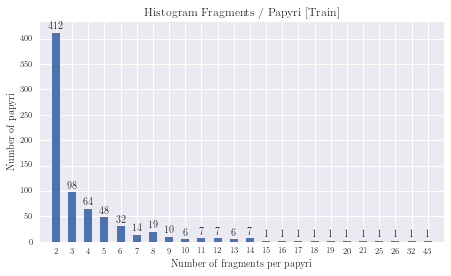

 Create Train Data Set DONE


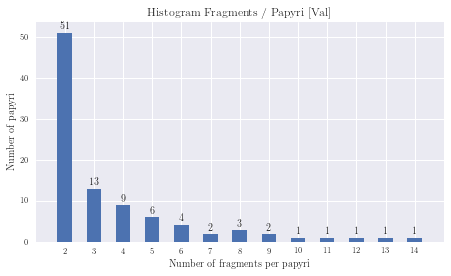

 Create Val Data Set DONE


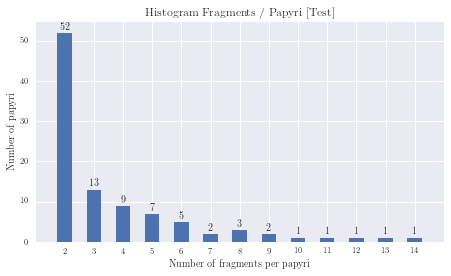

 Create Test Data Set DONE
 Create Train Data Loader DONE
 Create Val Data Loader DONE
 Create Test Data Loader DONE
 Optimizer SGD
 distance CosineSimilarity
 reducer: ThresholdReducer
 loss_function TripletMarginLoss
Epoch 1 -------------------------
 Training:
  Mined Tiplets 372
  Loss 0.398907333612442
 Training:
  Mined Tiplets 324
  Loss 0.6365346312522888
 Training:
  Mined Tiplets 552
  Loss 0.38047143816947937
 Validation:
  Mined Tiplets: 1663
  Loss0.40066206455230713
100%|██████████| 11/11 [00:13<00:00,  1.20s/it]
None of the query labels are in the reference set.
  AMI 0.042554447705149684
  NMI 0.6833755148702841
  MAP 0
  P@1 0
Epoch 2 -------------------------
 Training:
  Mined Tiplets 238
  Loss 0.5757594704627991
 Training:
  Mined Tiplets 243
  Loss 0.3490995466709137
 Training:
  Mined Tiplets 584
  Loss 0.4440927803516388
 Validation:
  Mined Tiplets: 1478
  Loss0.401170015335083
100%|██████████| 11/11 [00:13<00:00,  1.18s/it]
None of the query labels are in the 

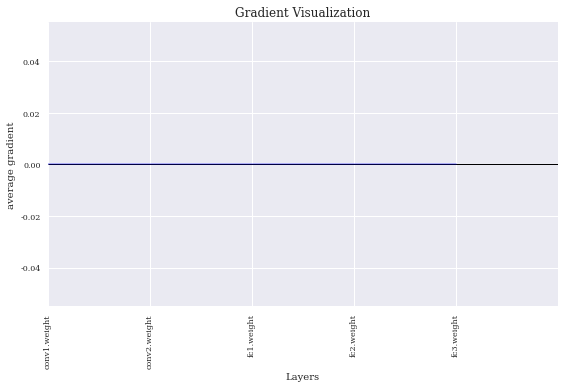

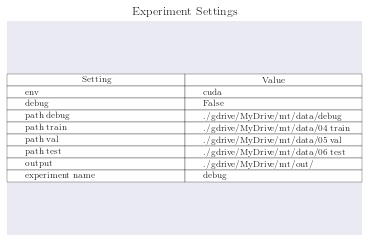

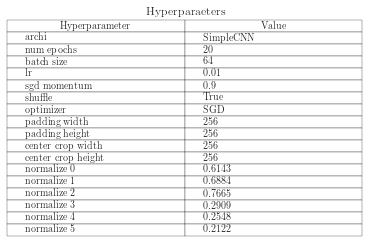

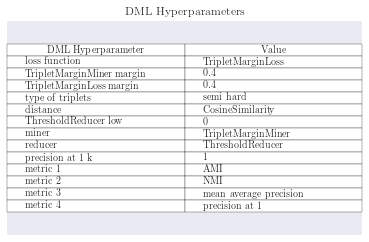

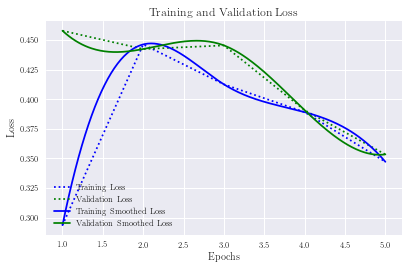

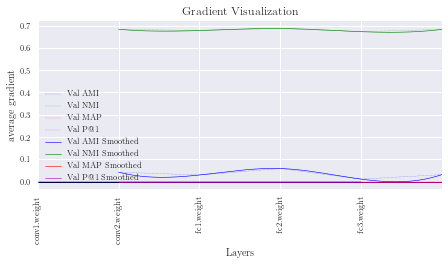

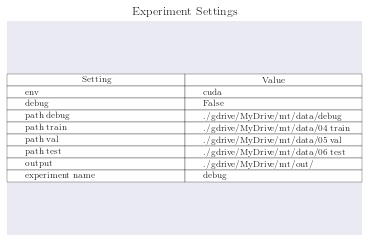

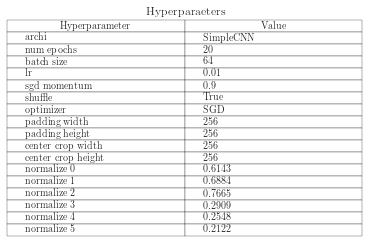

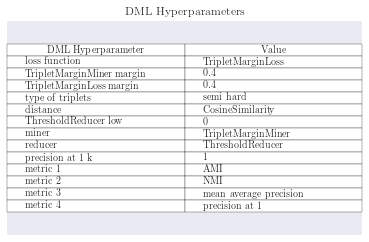

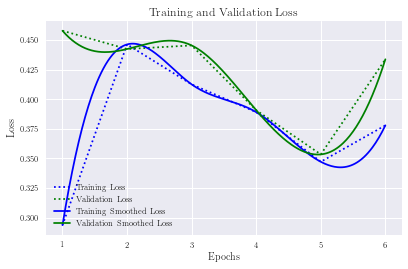

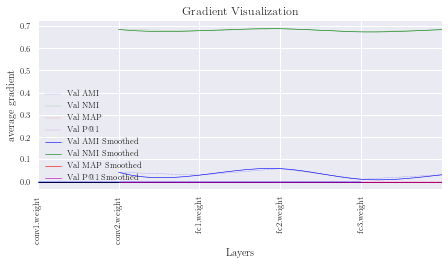

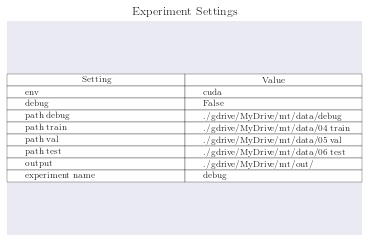

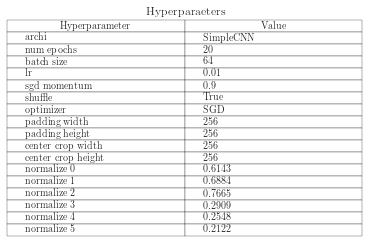

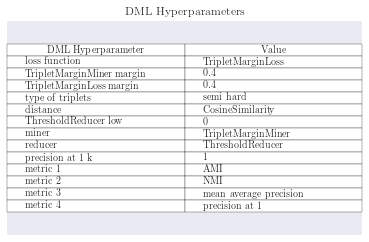

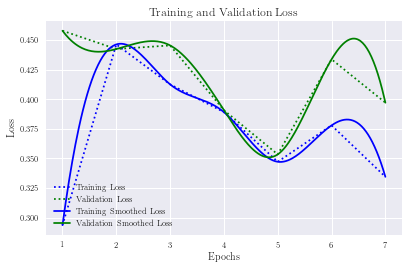

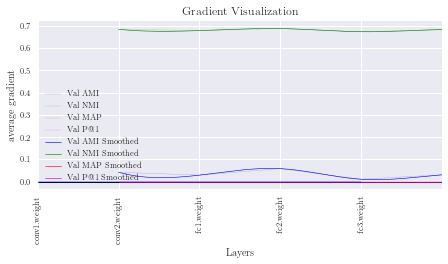

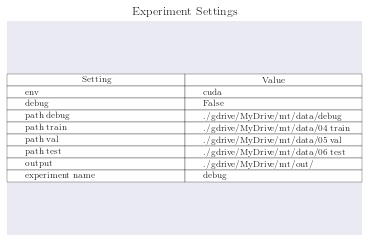

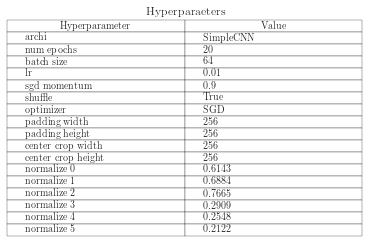

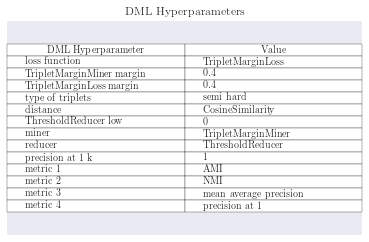

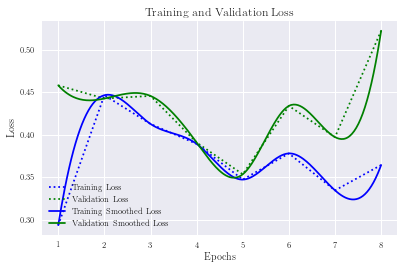

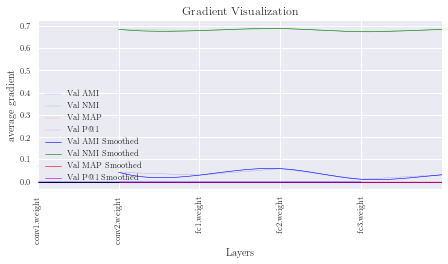

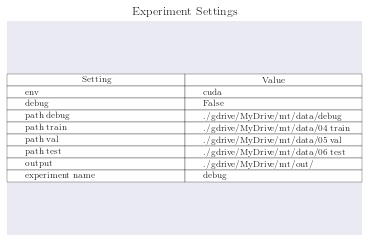

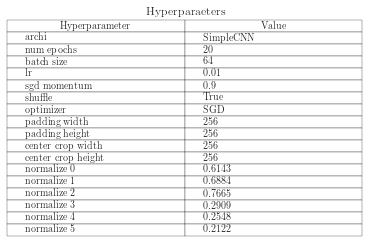

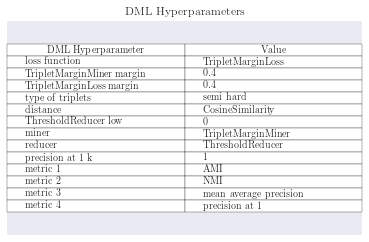

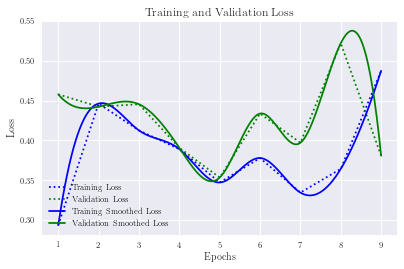

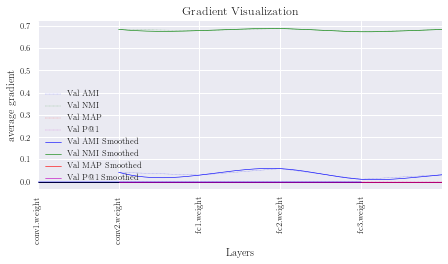

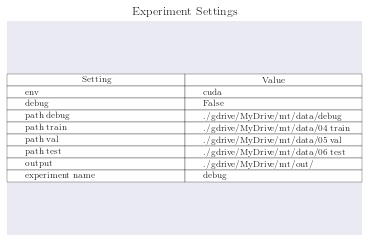

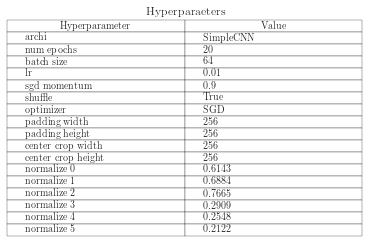

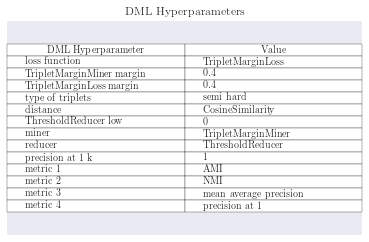

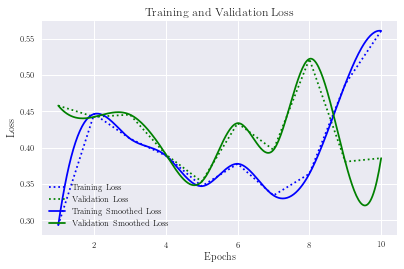

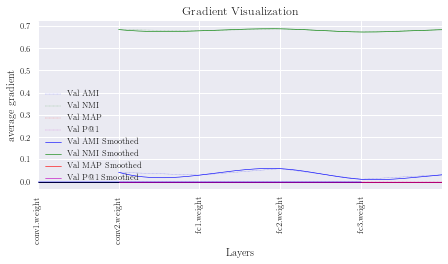

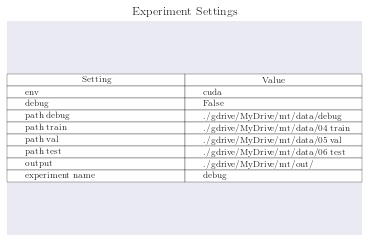

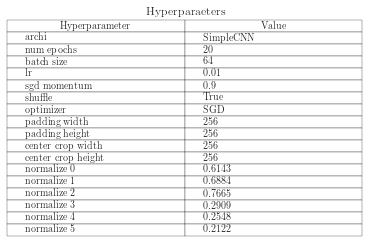

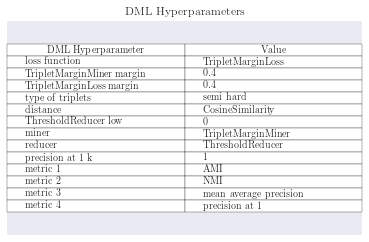

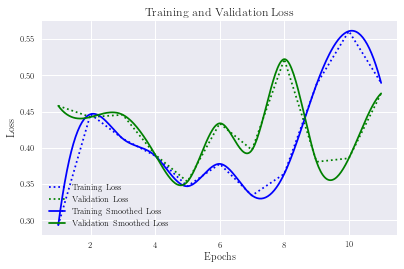

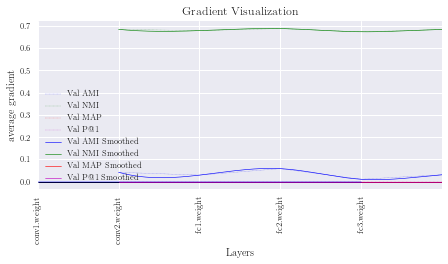

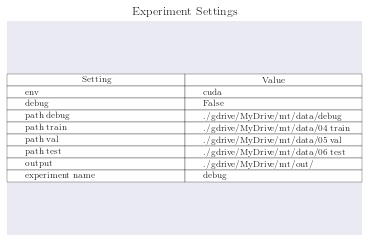

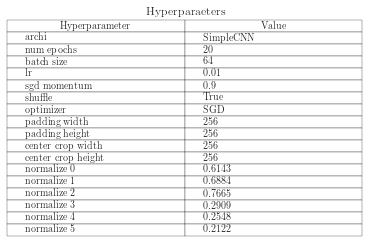

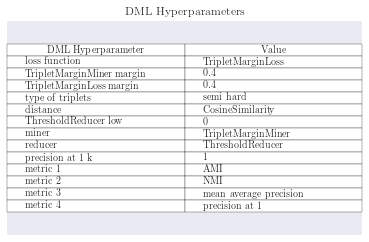

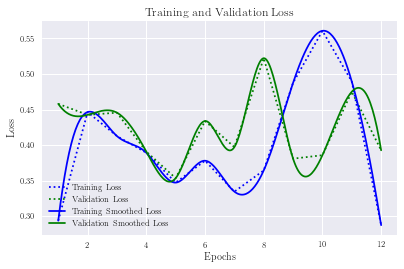

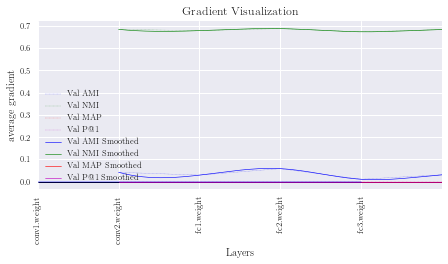

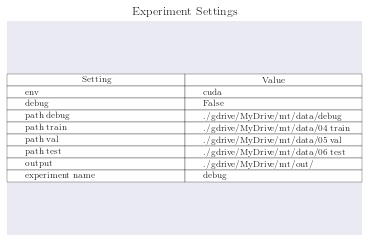

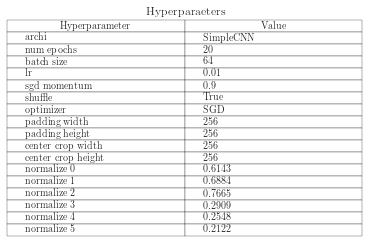

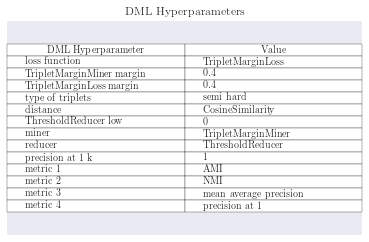

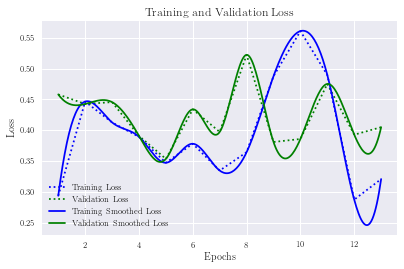

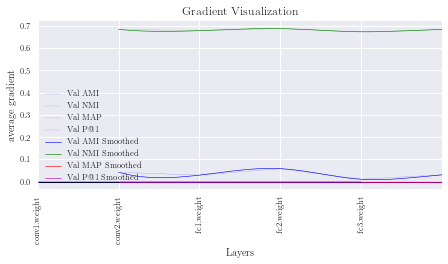

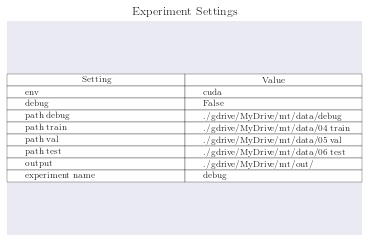

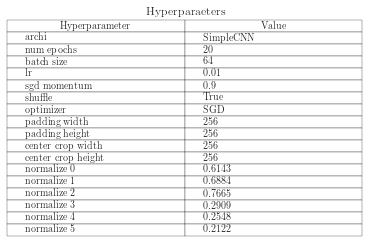

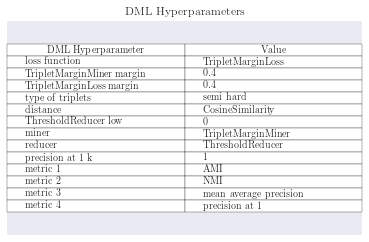

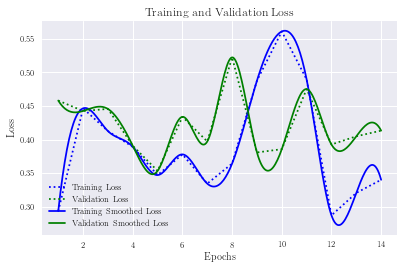

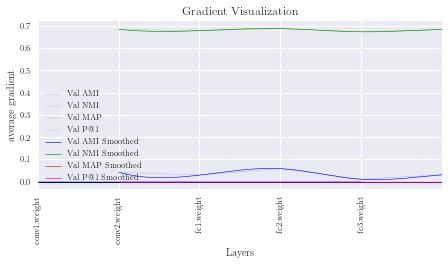

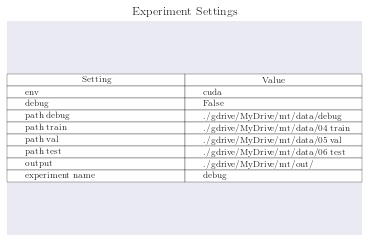

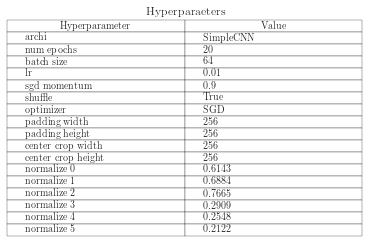

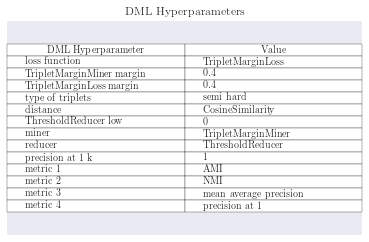

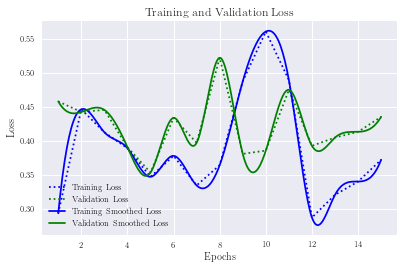

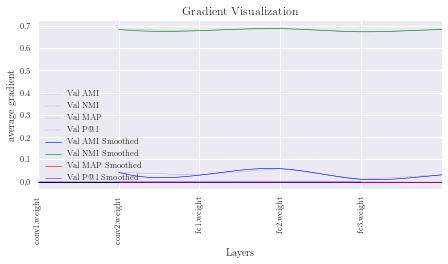

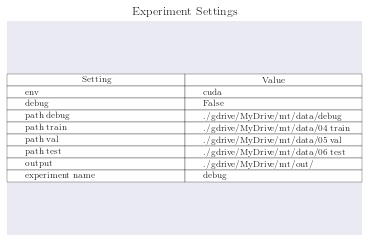

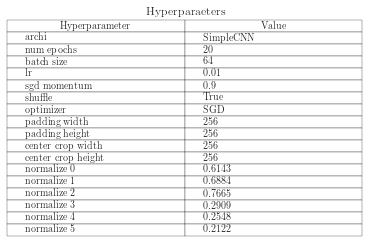

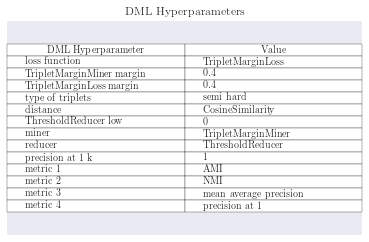

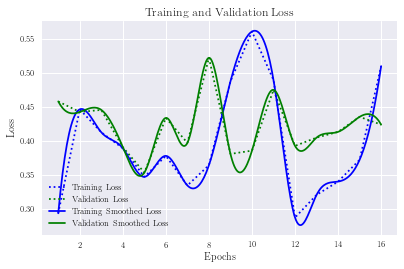

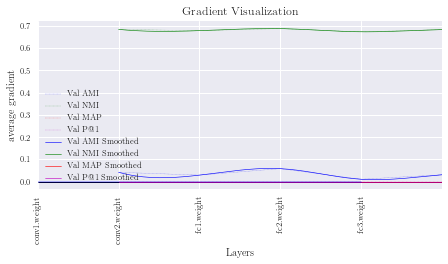

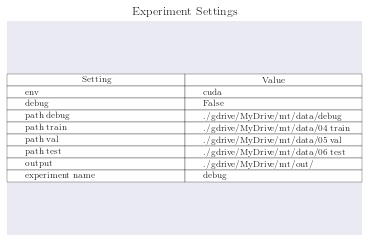

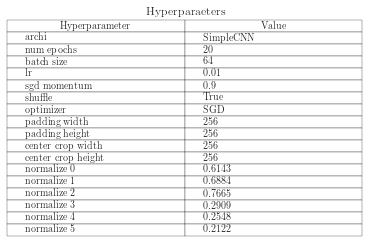

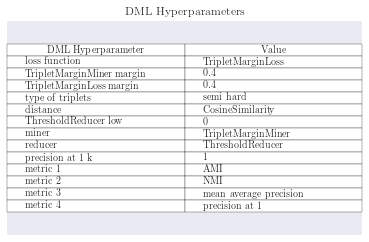

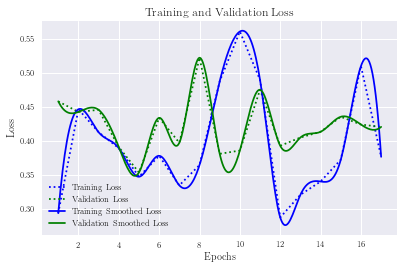

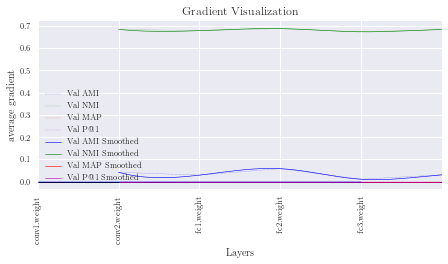

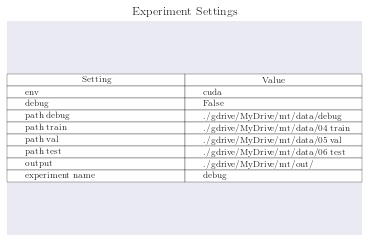

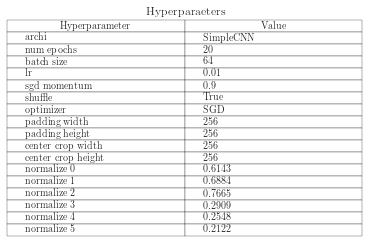

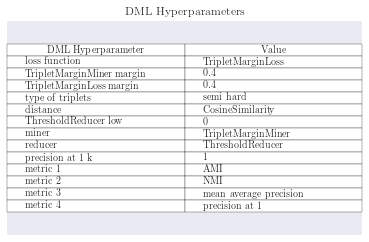

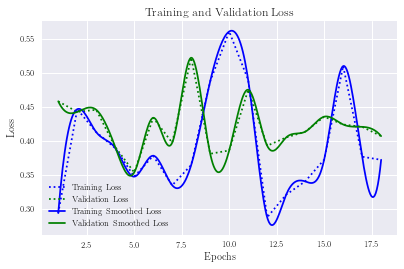

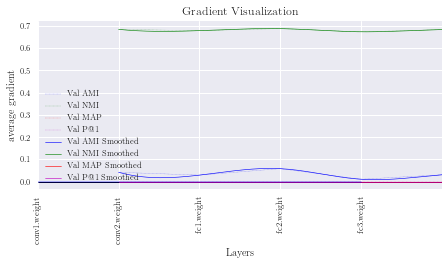

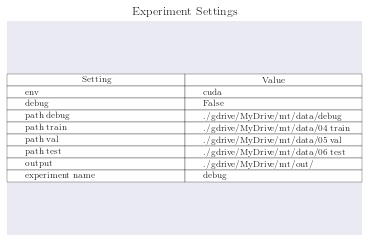

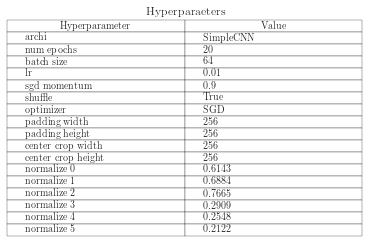

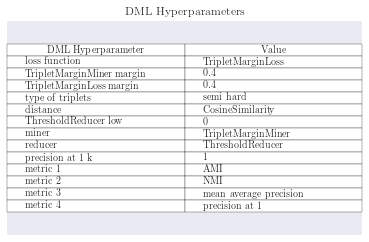

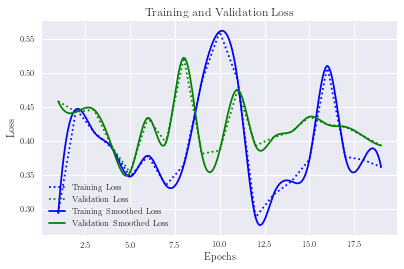

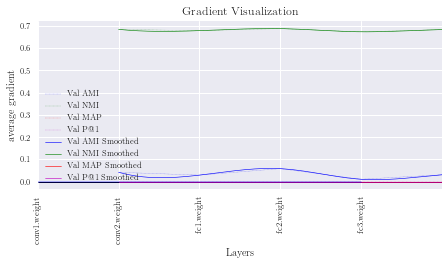

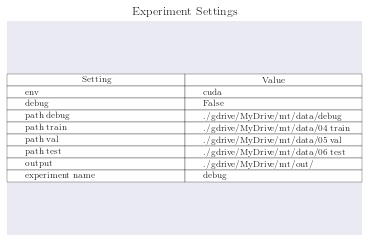

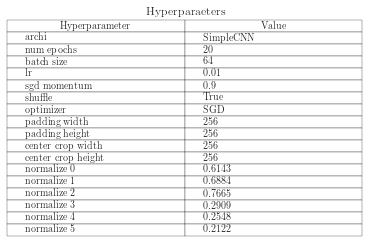

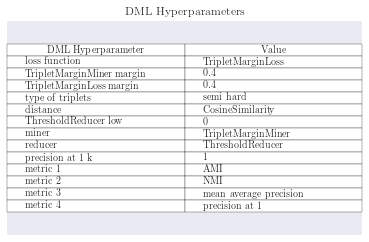

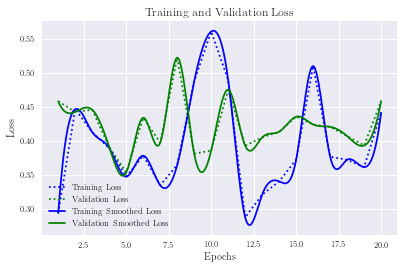

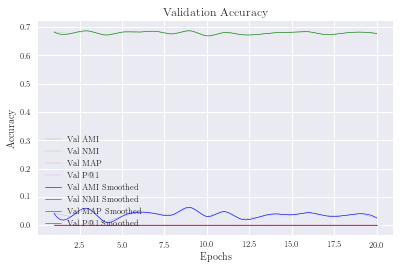

In [26]:
train_and_validate(config_path = './gdrive/MyDrive/mt/conf/conf.toml')